In [18]:
# dataset used: https://github.com/VildMedPap/countryflags/tree/master

import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

In [2]:
# read flags.csv
df_flags = pd.read_csv("flags.csv")

In [86]:
df_flags['image_name']
filenames = []
for i in range(len(df_flags['image_name'])):
    filenames.append("./flags/" + df_flags['image_name'][i].split(".")[0] + ".png")

In [123]:
# read images with cv2
images = []
for i in range(len(filenames)):
    images.append(cv2.imread(filenames[i]))
    # convert BGR to RGB
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

# convert images to PIL to allow transforms
images_pil = []
for i in range(len(images)):
    images_pil.append(Image.fromarray(images[i]))

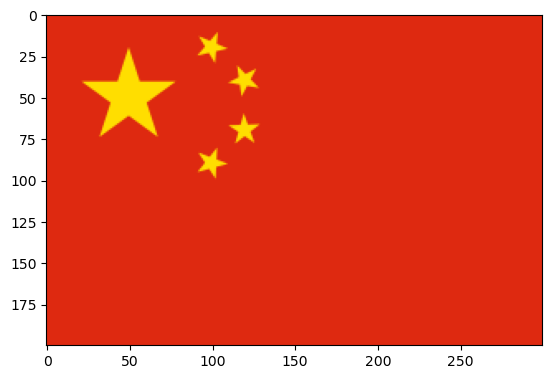

In [124]:
# display
plt.imshow(images_pil[0])

In [206]:
# convert images to tensors of size 256x256

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )])

# convert images to tensor
images_tensor = []
for i in range(len(images_pil)):
    images_tensor.append(transform(images_pil[i]))
    # normalize range [0,1]
    images_tensor[i] = (images_tensor[i] - images_tensor[i].min()) / (images_tensor[i].max() - images_tensor[i].min())

#split train, test randomly in pytorch
#generate 80% of indices randomly
train_indices = torch.randperm(len(images_tensor))[:int(len(images_tensor)*0.8)]
#use train indices to get elements from dataset
train_images = [images_tensor[i] for i in train_indices]
#use the rest of the data for test
test_images = [images_tensor[i] for i in range(len(images_tensor)) if i not in train_indices]



In [267]:
# source: https://www.kaggle.com/code/ljlbarbosa/convolution-autoencoder-pytorch

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  
        # conv layer (depth from 64 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(128, 32, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## upsample twice and then conv layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d_conv1 = nn.Conv2d(32, 128, 3, padding=1)
        self.d_conv2 = nn.Conv2d(128, 3, 3, padding=1)

    def forward(self, x):
        ## encode ##
        x = self.encode(x)
        ## decode ##
        x = self.decode(x)
        return x
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #x = F.relu(self.conv3(x))
        #x = self.pool(x)
        return x

    def decode(self, x):
        x = self.upsample(x)
        x = F.relu(self.d_conv1(x))
        x = self.upsample(x)
        x = F.sigmoid(self.d_conv2(x))
        return x
# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (d_conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_conv2): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [268]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 30


In [269]:
# train the model
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for image in train_images:
        train_data = image.unsqueeze(0)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(train_data)
        # calculate the loss
        loss = criterion(outputs, train_data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*train_data.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_images)

    
    # compute validation loss too
    test_loss = 0.0
    for image in test_images:
        test_data = image.unsqueeze(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(test_data)
        # calculate the loss
        loss = criterion(outputs, test_data)
        # update running validation loss 
        test_loss += loss.item()*test_data.size(0)

    # print avg training statistics
    test_loss = test_loss/len(test_images)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        test_loss
        ))
    

Epoch: 1 	Training Loss: 0.025013 	Validation Loss: 0.005172
Epoch: 2 	Training Loss: 0.005922 	Validation Loss: 0.004848
Epoch: 3 	Training Loss: 0.004706 	Validation Loss: 0.004073
Epoch: 4 	Training Loss: 0.004995 	Validation Loss: 0.004455
Epoch: 5 	Training Loss: 0.004362 	Validation Loss: 0.003837
Epoch: 6 	Training Loss: 0.003681 	Validation Loss: 0.003293
Epoch: 7 	Training Loss: 0.003651 	Validation Loss: 0.003763
Epoch: 8 	Training Loss: 0.003612 	Validation Loss: 0.002858
Epoch: 9 	Training Loss: 0.002836 	Validation Loss: 0.002628
Epoch: 10 	Training Loss: 0.002683 	Validation Loss: 0.002300
Epoch: 11 	Training Loss: 0.002565 	Validation Loss: 0.002567
Epoch: 12 	Training Loss: 0.002683 	Validation Loss: 0.002097
Epoch: 13 	Training Loss: 0.001996 	Validation Loss: 0.002351
Epoch: 14 	Training Loss: 0.003664 	Validation Loss: 0.002613
Epoch: 15 	Training Loss: 0.002554 	Validation Loss: 0.002344
Epoch: 16 	Training Loss: 0.002158 	Validation Loss: 0.002014
Epoch: 17 	Traini

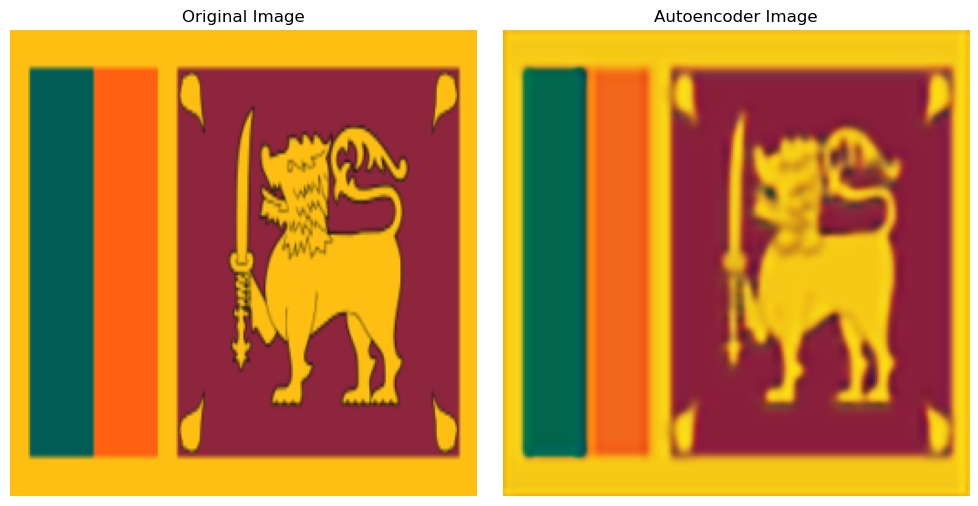

In [271]:
index = 15
# generate sample outputs
output = model(test_images[index].unsqueeze(0))
output = output.detach().numpy()

# display original image and reconstructed image
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))

# plot original image
axes[0].imshow(test_images[index].permute(1, 2, 0))
axes[0].set_title('Original Image')

# plot reconstructed image
axes[1].imshow(output[0].transpose(1, 2, 0))
axes[1].set_title('Autoencoder Image')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()


In [272]:
# get latent representation for all images
latent = []
for i in range(len(images_tensor)):
    latent.append(model.encode(images_tensor[i].unsqueeze(0)).detach().numpy())

In [273]:
latent[0].shape

(1, 32, 64, 64)

In [274]:
# display features as clusters
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [275]:
#each element in images_features is a tensor of size 1x512x8x8 which represents one image
#convert all list elements to a numpy array of size 2 with TSNE for dimensionality reduction and clustering

shape_1, shape_2, shape_3 = latent[0].shape[1:]

images_features_np = []
for i in range(len(latent)):
    images_features_np.append(latent[i].reshape(shape_1*shape_2*shape_3))

images_features_np = np.array(images_features_np)

# reduce dimensionality to 2
tsne = TSNE(n_components=2, random_state=0)
images_features_np_2d = tsne.fit_transform(images_features_np)


[]

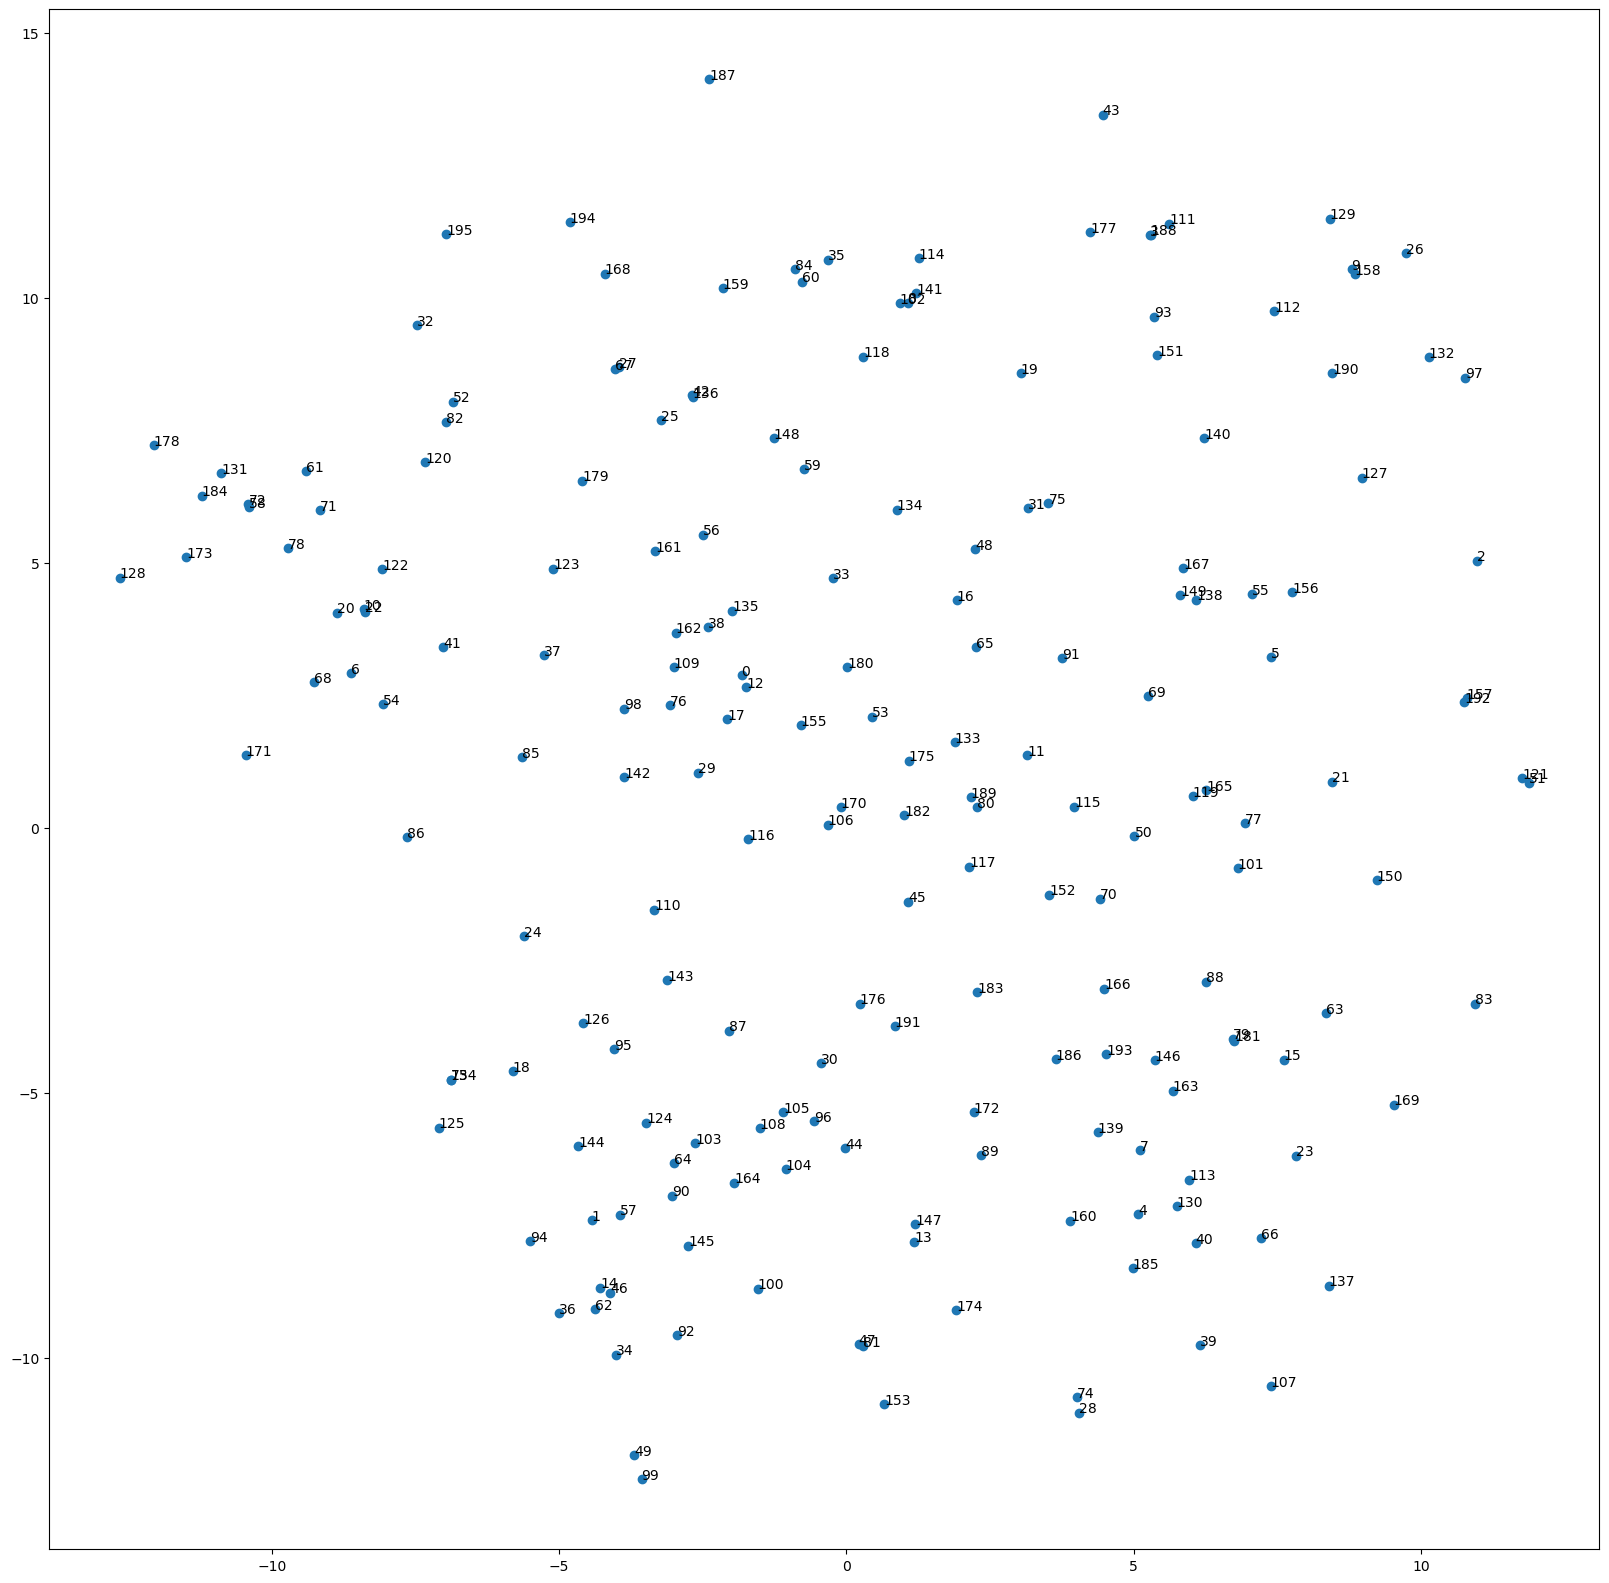

In [276]:
#plot and display index on each dot with only the first 10 layers of the vgg16 feature block is used
x = images_features_np_2d[:,0]
y = images_features_np_2d[:,1]
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y)
for i, txt in enumerate(df_flags['image_name']):
    ax.annotate(i, (x[i], y[i]))
plt.plot()

In [277]:
def display_two_flags(index_1, index_2):
    # given two indices, display the two flags and their respective country names
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(images[index_1])
    ax[1].imshow(images[index_2])
    #title with respective country names
    ax[0].set_title(df_flags['country'][index_1])
    ax[1].set_title(df_flags['country'][index_2])
    plt.show()

In [278]:
# convert country name to index
def get_index(country):
    for i in range(len(df_flags['country'])):
        if df_flags['country'][i] == country:
            return i
    return -1

In [279]:
def get_distance(x, y, index_1, index_2):
    # given two indices and the TSNE reduced dimensionality array, return the euclidean distance between the two points
    return np.sqrt((x[index_1] - x[index_2])**2 + (y[index_1] - y[index_2])**2)

In [280]:
# get closest countries to a given country
def get_closest_countries(country):
    index = get_index(country)
    if index == -1:
        print("Country not found")
        return
    distances = []
    for i in range(len(df_flags['country'])):
        distances.append(get_distance(x, y, index, i))
    # sort distances maintaining the index
    distances = np.array(distances)
    distances_sorted = np.argsort(distances)
    return distances_sorted, distances
    
    

In [281]:
def get_distance_and_flags(index_1, index_2):
    distance = get_distance(x, y, index_1, index_2)
    print("Distance between {} and {} is {}".format(df_flags['country'][index_1], df_flags['country'][index_2], distance))
    display_two_flags(index_1, index_2)

In [282]:
# get country index 20
df_flags['country'][20]

'France'

Distance between Chile and The Czech Republic is 0.2637371375594558
Distance between Chile and Poland is 0.6074680049067376
Distance between Chile and Comoros is 1.3958189042439368
Distance between Chile and Bulgaria is 1.7416811417584495
Distance between Chile and Oman is 1.7647724067913013
Distance between Chile and Russia is 1.873754923653047
Distance between Chile and Slovenia is 1.9881491479048674
Distance between Chile and Slovakia is 2.0730347860635843
Distance between Chile and Venezuela is 2.8724451608149146
Distance between Chile and Lithuania is 2.900024758743173
Distance between Chile and The Czech Republic is 0.2637371375594558


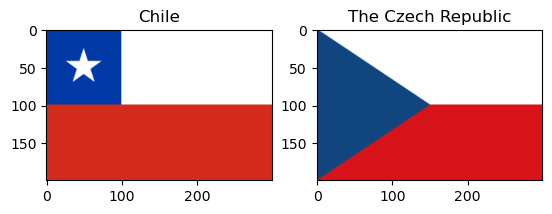

In [305]:
country_1 = "Chile"
# display closest 10 countries and their distances, ignoring itself
closest_countries, distances = get_closest_countries(country_1)
for i in range(1, 11):
    print("Distance between {} and {} is {}".format(country_1, df_flags['country'][closest_countries[i]], distances[closest_countries[i]]))
#display flag of closest country
get_distance_and_flags(get_index(country_1), get_index(df_flags['country'][closest_countries[1]]))

In [168]:
closest_countries

array([ 71,  61,  58,  10,  20,  22, 131,  72, 184,  78, 122,  41, 173,
        54,  37,   6, 148, 171,  68, 120, 159, 160, 169, 121,  51, 128,
       161, 179,  82, 174,  77,  86, 192, 166, 157, 186,  84,  60, 193,
        97,  27,  67, 137,  79, 146,  35, 147, 194, 181, 163, 132,  89,
        25, 136, 156, 102,  40,  30, 172,  42, 167, 141, 123, 104, 195,
         5,  63,   8,  44, 191,  24,  55, 113,  96, 114,   4, 176, 130,
       138, 105, 149,  75, 108, 158, 190, 178, 185,  66,  69, 139, 101,
       144,  26,  15,  11,   7,  31,   9,  83,  23,  43, 112,  52, 183,
        56,  13, 152, 127, 140, 168, 117,  32,  87,  18, 115,   2,   1,
       129, 154,  73,  50, 177,  70, 153,  59,  21, 118, 126, 125, 111,
       188,   3,  57,  92,  88,  48,  93, 164, 151,  94, 134,  81,  90,
        47, 145, 165, 103, 119,  64,  16,  65,  74,  29, 100,  28, 124,
        34, 133,  46,  91,  14,  19,  62,  36,  33, 107, 116,  95,  39,
       106,  45, 187,  99,  49, 170, 182, 143, 110, 189, 155,  8

Distance between Moldova and Spain is 8.663660077299383


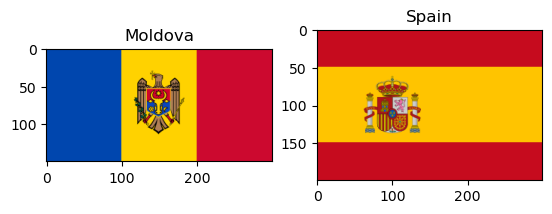

In [263]:
country_1 = "Moldova"
country_2 = "Spain"
get_distance_and_flags(get_index(country_1), get_index(country_2))

In [113]:
#get names of all countries
set(df_flags['country'])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Denmark',
 'Djibouti',
 'Dominica',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 "Ivory Coast - Côte d'Ivoire",
 'Jamaica',
 

[]

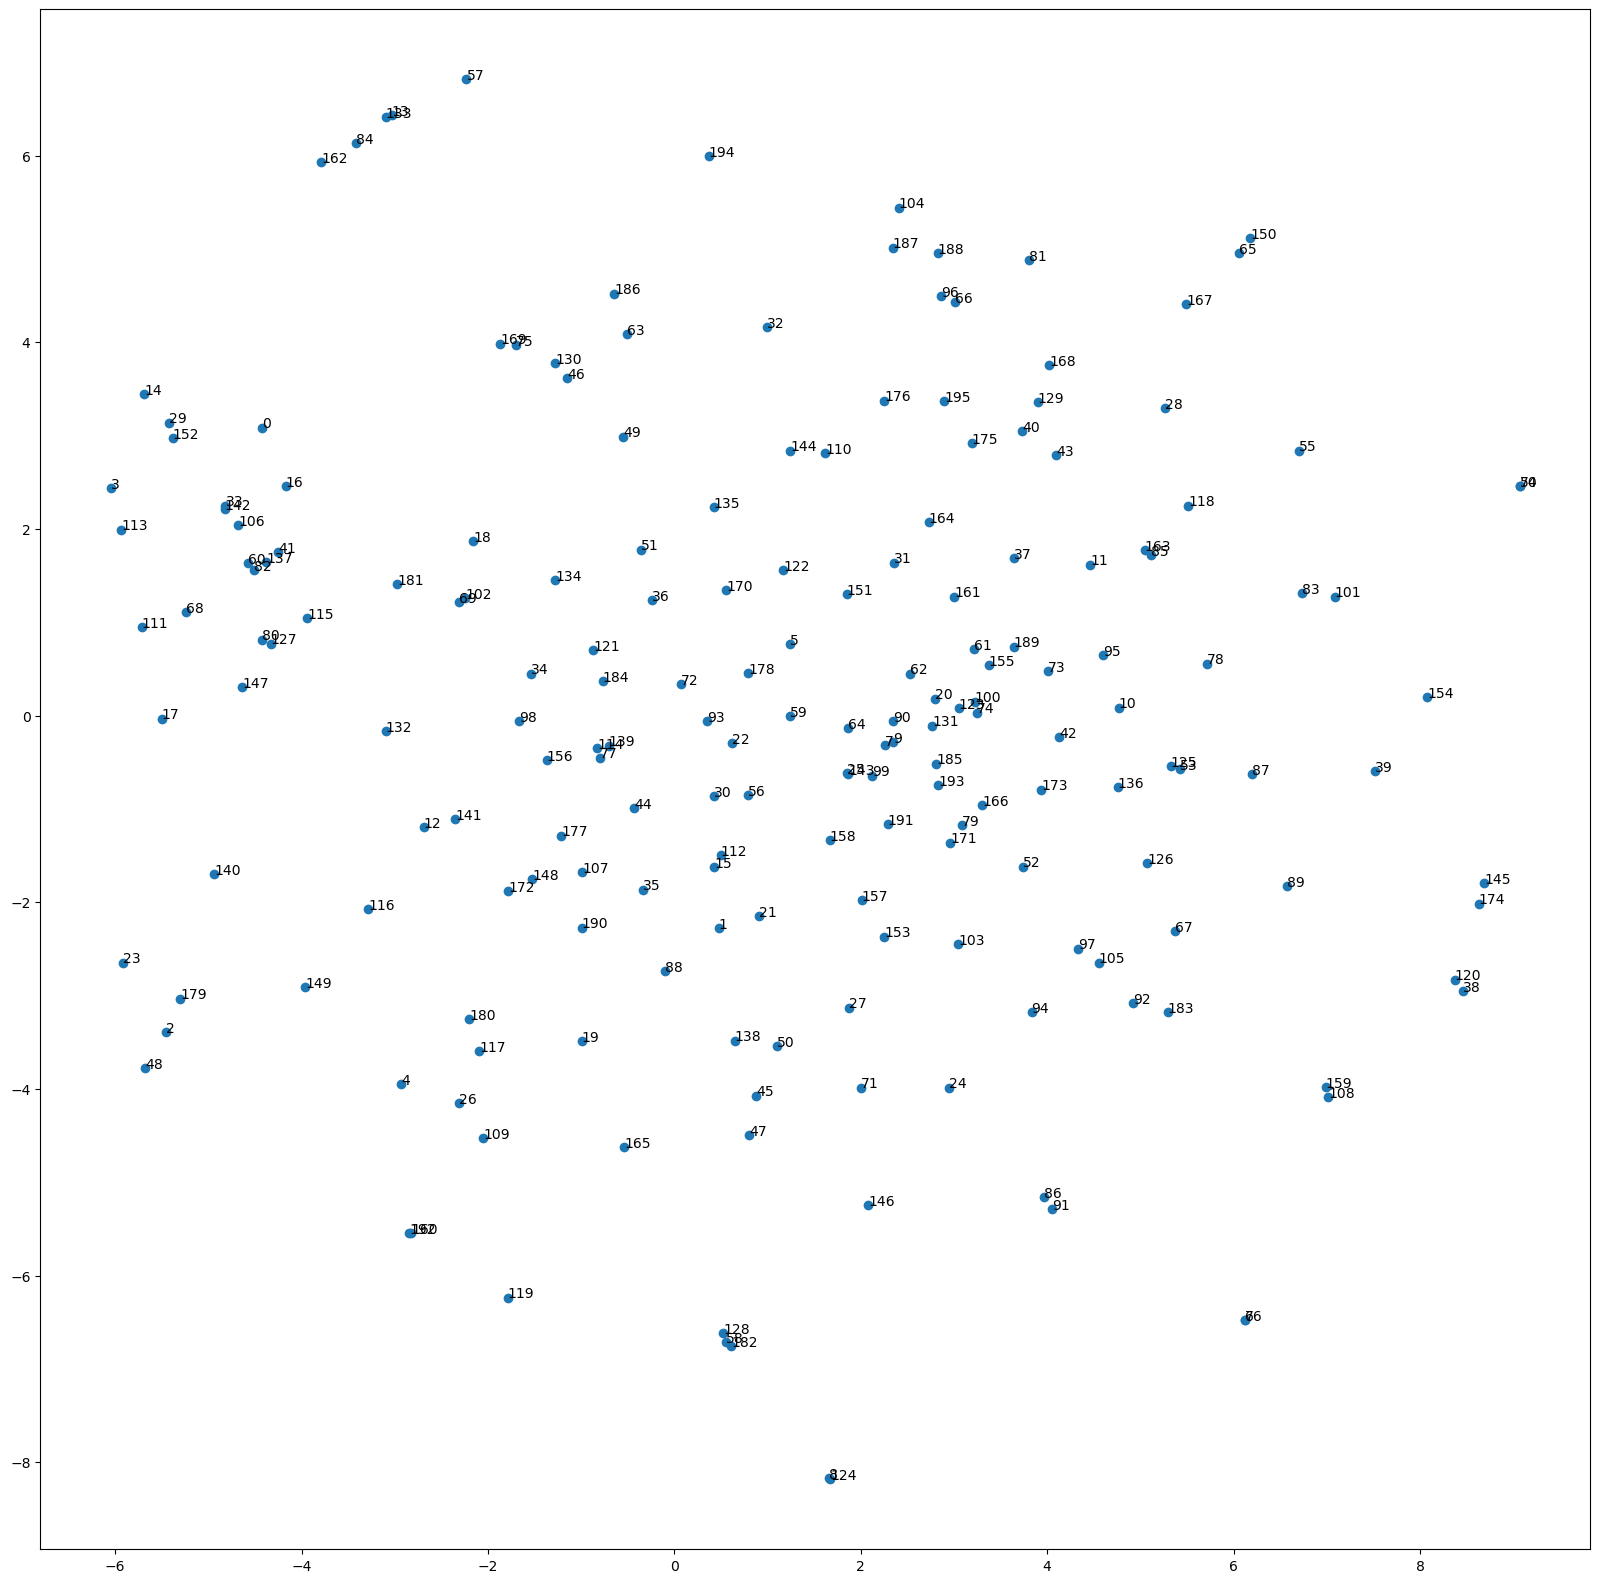

In [68]:
#plot and display index on each dot where the entire feature block of vgg16 is used
x = images_features_np_2d[:,0]
y = images_features_np_2d[:,1]
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y)
for i, txt in enumerate(df_flags['image_name']):
    ax.annotate(i, (x[i], y[i]))
plt.plot()

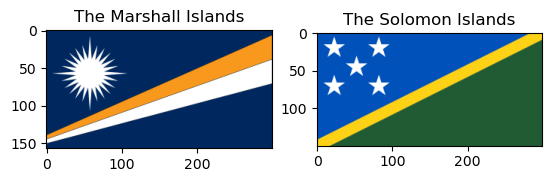

In [71]:
# display images 108, 159 in a subfigure of 2
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[108])
ax[1].imshow(images[159])
#title with respective country names
ax[0].set_title(df_flags['country'][108])
ax[1].set_title(df_flags['country'][159])
plt.show()

In [52]:
# compute distance between feature of image 77 and image 139
import torch.nn.functional as F
#indonesia, poland
distance = F.pairwise_distance(images_features[77], images_features[139])
distance.sum()

tensor(534.3932)

In [51]:
#moldova, andorra
distance = F.pairwise_distance(images_features[3], images_features[113])
distance.sum()

tensor(3400.8291)

In [54]:
#romania, chad
distance = F.pairwise_distance(images_features[142], images_features[33])
distance.sum()

tensor(130.1015)

In [55]:
distance = F.pairwise_distance(images_features[33], images_features[33])
distance.sum()

tensor(0.0116)

In [35]:
#sort df_flags by image_name
df_flags.sort_values(by=['image_name'], inplace=True)
# reset index
df_flags.reset_index(inplace=True)

In [53]:
#get entry of country Indonesia
print(df_flags[df_flags['country'] == 'Romania']['country'])
print(df_flags[df_flags['country'] == 'Chad']['country'])

142    Romania
Name: country, dtype: object
33    Chad
Name: country, dtype: object


In [37]:
df_flags.head()

,index,country,capital,continent,languages,government,population,flag_height,flag_width,flag_colors,...,currency,cet,cest,internet_tld,country_letter_code,country_digit_code,calling_code,borders_to,countryflags_url,image_name
0,39,Afghanistan,Kabul,Asia,Pashto and Dari,Unitary presidential Islamic republic,32564342,2.0,3.0,"['black', 'red', 'green', 'white']",...,afghani (afn),utc+4:30,utc+4:30,af,afg,4,93,"['china', 'iran', 'pakistan', 'tajikistan', 't...",https://www.countryflags.com/en/flag-of-afghan...,afghanistan-flag.svg
1,135,Albania,Tirana,Europe,Albanian,Unitary parliamentary constitutional republic,2891155,5.0,7.0,"['red', 'black']",...,lek (all),utc+01:00,utc+02:00,al,alb,8,355,"['greece', 'kosovo', 'macedonia', 'montenegro']",https://www.countryflags.com/en/flag-of-albani...,albania-flag.svg
2,32,Algeria,Algiers,Africa,Arabic,Unitary semi-presidential republic,40763971,2.0,3.0,"['green', 'white', 'red']",...,dinar (dzd),utc+01:00,utc+01:00,dz,dza,12,213,"['libya', 'mali', 'mauritania', 'morocco', 'ni...",https://www.countryflags.com/en/flag-of-algeri...,algeria-flag.svg
3,184,Andorra,Andorra la Vella,Europe,Catalan,Unitary parliamentary diarchy,72090,7.0,10.0,"['blue', 'red', 'yellow']",...,euro € (eur),utc+01:00,utc+02:00,ad,and,20,376,"['france', 'spain']",https://www.countryflags.com/en/flag-of-andorr...,andorra-flag.svg
4,49,Angola,Luanda,Africa,Portuguese,Unitary presidential republic,26197332,2.0,3.0,"['red', 'yellow', 'black']",...,angolan kwanza kz (aoa),utc+01:00,utc+01:00,ao,ago,24,244,"['congo, democratic republic of the', 'congo, ...",https://www.countryflags.com/en/flag-of-angola...,angola-flag.svg
